# Welcome to RAD-MMM inference tutorial

Before we begin, please download the following dependencies:

1. Language dictionaries from [here](https://drive.google.com/drive/folders/1woNCODwXh9aHu7Fd6b4Jo42aL7f5RFZg) and place them in `RAD-MMM/assets` folder.
2. Download RAD-MMM checkpoint and its config - [radmmm_converged_decoder_attribute_predictors.ckpt](https://drive.google.com/file/d/1m-pAIeCBuT6yD77kIETqkAYYDtA_cbzs/view?usp=sharing), and [config.yaml](https://drive.google.com/file/d/1sPFFy6aYufbseox5Rxwt-EjDbMogkUwP/view?usp=sharing).
3. Download HiFi-GAN vocoder checkpoint and its config - [g_00072000](https://drive.google.com/file/d/1VaH5_MhAjAjHlihi2k-lcOOoy4NqtRV4/view) and [config_16khz.json](https://drive.google.com/file/d/1-eBTNfIh-LSstNirQawHW4jsI-t01jTU/view?usp=sharing).

In [1]:
# imports
import pytorch_lightning as pl
import sys
import yaml
sys.path.append('vocoders')
from pytorch_lightning.cli import LightningCLI
from tts_lightning_modules import TTSModel
from data_modules import BaseAudioDataModule
from jsonargparse import lazy_instance
from decoders import RADMMMFlow
from loss import RADTTSLoss
import inspect
from pytorch_lightning.callbacks import ModelCheckpoint
from training_callbacks import LogDecoderSamplesCallback, \
    LogAttributeSamplesCallback
from utils import get_class_args
from tts_text_processing.text_processing import TextProcessing
from common import Encoder
import torch
import IPython.display as ipd

In [2]:
#ToDo: Set paths for downloaded files
radmmm_model_path = "/path/to/radmmm_converged_decoder_attribute_predictors.ckpt"
gen_config_path = "/path/to/config.yaml"
voc_model_path = "/path/to/g_00072000"
voc_config_path = "/path/to/config_16khz.json"
phonemizer_cfg='{"en_US": "assets/en_US_word_ipa_map.txt","es_MX": "assets/es_MX_word_ipa_map.txt","de_DE": "assets/de_DE_word_ipa_map.txt","en_UK": "assets/en_UK_word_ipa_map.txt","es_CO": "assets/es_CO_word_ipa_map.txt","es_ES": "assets/es_ES_word_ipa_map.txt","fr_FR": "assets/fr_FR_word_ipa_map.txt","hi_HI": "assets/hi_HI_word_ipa_map.txt","pt_BR": "assets/pt_BR_word_ipa_map.txt","te_TE": "assets/te_TE_word_ipa_map.txt"}'

In [3]:
#ToDo: Set paths for downloaded files
radmmm_model_path = "../generator_ckpt/radmmm_public/radmmm_converged_decoder_attribute_predictors.ckpt"
gen_config_path = "../generator_ckpt/radmmm_public/config.yaml"
voc_model_path = "../generator_ckpt/hfg_public/g_00072000"
voc_config_path = "../generator_ckpt/hfg_public/config_16khz.json"
phonemizer_cfg='{"en_US": "assets/en_US_word_ipa_map.txt", "hi_HI": "assets/hi_HI_word_ipa_map.txt"}'
# phonemizer_cfg='{"en_US": "assets/en_US_word_ipa_map.txt","es_MX": "assets/es_MX_word_ipa_map.txt","de_DE": "assets/de_DE_word_ipa_map.txt","en_UK": "assets/en_UK_word_ipa_map.txt","es_CO": "assets/es_CO_word_ipa_map.txt","es_ES": "assets/es_ES_word_ipa_map.txt","fr_FR": "assets/fr_FR_word_ipa_map.txt","hi_HI": "assets/hi_HI_word_ipa_map.txt","pt_BR": "assets/pt_BR_word_ipa_map.txt","te_TE": "assets/te_TE_word_ipa_map.txt"}'

## Load the model

In [4]:
# load the config

with open(gen_config_path, "r") as f:
    gen_config = yaml.safe_load(f)

In [5]:
def instantiate_class(init):
    """Instantiates a class with the given args and init.

    Args:
        args: Positional arguments required for instantiation.
        init: Dict of the form {"class_path":...,"init_args":...}.

    Returns:
        The instantiated class object.
    """
    kwargs = init.get("init_args", {})
    class_module, class_name = init["class_path"].rsplit(".", 1)
    module = __import__(class_module, fromlist=[class_name])
    args_class = getattr(module, class_name)
    return args_class(**kwargs)

In [6]:
# instantiate submodules

gen_config["model"]["add_bos_eos_to_text"] = False
gen_config["model"]["append_space_to_text"] = True
gen_config["model"]["decoder_path"] = radmmm_model_path
gen_config["model"]["encoders_path"] = radmmm_model_path
gen_config["model"]["handle_phoneme"] = "word"
gen_config["model"]["handle_phoneme_ambiguous"] = "ignore"
gen_config["model"]["heteronyms_path"] = "tts_text_processing/heteronyms"
gen_config["model"]["output_directory"] = "tutorials/run1"
gen_config["model"]["p_phoneme"] = 1
gen_config["model"]["phoneme_dict_path"] = "tts_text_processing/cmudict-0.7b"
gen_config["model"]["phonemizer_cfg"] = phonemizer_cfg
gen_config["model"]["prediction_output_dir"] = "tutorials/out1"
gen_config["model"]["prepend_space_to_text"] = True
gen_config["model"]["sampling_rate"] = 16000
gen_config["model"]["symbol_set"] = "radmmm_phonemizer_marker_segregated"
gen_config["model"]["vocoder_checkpoint_path"] = voc_model_path
gen_config["model"]["vocoder_config_path"] = voc_config_path

hparams = gen_config["model"]
ttsmodel_kwargs={}
for k,v in hparams.items():
    if type(v) == dict and 'class_path' in v:
        print(k)
        ttsmodel_kwargs[k] = instantiate_class(v)
    elif k != "_instantiator":
        ttsmodel_kwargs[k] = v

decoder


/akshit/scratch/RAD-MMM/common.py:557: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at /opt/conda/conda-bld/pytorch_1678411187366/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2425.)
  W = torch.qr(torch.FloatTensor(c, c).normal_())[0]
/opt/conda/lib/python3.10/site-packages/torch/functional.py:1728: UserWarning: torch.lu is deprecated in favor of torch.linalg.lu_factor / torch.linalg.lu_factor_ex and will be removed in a future PyTorch release.
LU, pivots = torch.lu(A, compute_pivots)
should be replaced with
LU, pivots = torch.linalg.lu_factor(A, compute_pivots)
and
LU, pivots, info = torch.lu(A, compute_pivots, get_infos=True)
should be replaced with
LU, pivots, info = torch.linalg.lu_factor_ex(A, compute_p

decoder_loss
text_encoder
Applying spectral norm to text encoder LSTM
f0_predictor
f0_predictor_loss
energy_predictor
energy_predictor_loss
voiced_predictor
voiced_predictor_loss
duration_predictor
duration_predictor_loss
speaker_embed_regularization_loss
speaker_accent_cross_regularization_loss


In [7]:
# load the model from checkpoint

device = "cuda" if torch.cuda.is_available() else "cpu"

model = TTSModel.load_from_checkpoint(checkpoint_path=radmmm_model_path,\
                                      **ttsmodel_kwargs).to(device=device)


loading:  assets/en_US_word_ipa_map.txt
loading:  assets/hi_HI_word_ipa_map.txt
Number of symbols: 439
updating the speakers set: 7
Initializing f0 predictor
ConvLSTMLinearDAP(
  (bottleneck_layer): BottleneckLayer(
    (projection_fn): ConvNorm(
      (conv): Conv1d(520, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    )
    (non_linearity): LeakyReLU(negative_slope=0.01)
  )
  (feat_pred_fn): ConvLSTMLinear(
    (dropout): Dropout(p=0.5, inplace=False)
    (convolutions): ModuleList(
      (0): ConvNorm(
        (conv): Conv1d(48, 256, kernel_size=(15,), stride=(1,), padding=(7,))
      )
      (1-2): 2 x ConvNorm(
        (conv): Conv1d(256, 256, kernel_size=(15,), stride=(1,), padding=(7,))
      )
    )
    (bilstm): LSTM(256, 128, batch_first=True, bidirectional=True)
    (dense): Linear(in_features=256, out_features=1, bias=True)
  )
)
Initializing energy predictor
ConvLSTMLinearDAP(
  (bottleneck_layer): BottleneckLayer(
    (projection_fn): ConvNorm(
      (conv): Conv1d(5

## Initialize the datamodule

In [8]:
# initialize the datamodule

gen_config["data"]["batch_size"]=1
gen_config["data"]["phonemizer_cfg"]=phonemizer_cfg
gen_config["data"]["inference_transcript"] = None 
data_module = BaseAudioDataModule(**gen_config['data'])
data_module.setup(stage = "predict")

loading:  assets/en_US_word_ipa_map.txt
loading:  assets/hi_HI_word_ipa_map.txt
Number of symbols: 439
{'basedir': '/home/dcg-adlr-rbadlani-data/multilingual-dataset/opensource/LJSpeech-1.0', 'sampling_rate': '16khz', 'filelist_basedir': 'datasets/opensource/', 'filelist': 'LJSpeech/ljs_audiopath_text_sid_emotion_duration_train_filelist_phonemized.txt', 'language': 'en_US', 'phonemized': True}
processing file: datasets/opensource/LJSpeech/ljs_audiopath_text_sid_emotion_duration_train_filelist_phonemized.txt
{'basedir': '/home/dcg-adlr-rbadlani-data/multilingual-dataset/opensource/HUI-Audio-Corpus-German/Bernd_Ungerer', 'sampling_rate': '16khz', 'filelist_basedir': 'datasets/opensource/', 'filelist': 'HUI-Audio-Corpus-German/Bernd_Ungerer/berndungerer_audiopath_text_sid_emotion_duration_train_filelist_filtered_phonemized.txt', 'language': 'de_DE', 'phonemized': True}
processing file: datasets/opensource/HUI-Audio-Corpus-German/Bernd_Ungerer/berndungerer_audiopath_text_sid_emotion_durati

## Run Inference

In [9]:
# run the input through the model
def run_inference(script, speaker_id, input_language_id, target_accent_id):
    
    inferData = [{
      "script": script,
      "spk_id": speaker_id,
      "decoder_spk_id": speaker_id,
      "duration_spk_id": speaker_id,
      "energy_spk_id": speaker_id,
      "f0_spk_id": speaker_id,
      "language": target_accent_id,
      "emotion": "other"
    }]
    
    ## set predictset
    data_module.predictset.data = inferData
    
    ## initialize and get the dataloader
    dl = data_module.predict_dataloader()
    
    ## get the first input
    inp = next(iter(dl))
    
    ## move the input tensors to GPU
    for k in inp.keys():
        if type(inp[k]) == torch.Tensor:
            inp[k] = inp[k].to(device=device)

    return model.forward(inp) 

In [10]:
# first example - Converting hindi text to phonemes

text = "आशा है कि आप अब तक हमारे सत्र का आनंद ले रहे हैं!"
speaker_id = "indic-iiit-hyd-female"
input_language_id = "hi_HI"

script = data_module.tp.convert_to_phoneme(text=text, phoneme_dict=data_module.tp.phonemizer_backend_dict[input_language_id])

print("Converted the sentence to phonemes: ", script)


word: ' आशा ', mapped to phoneme:  {ˈ a ː ʃ a ː}
word: ' है ', mapped to phoneme:  {h ɛ ː}
word: ' कि ', mapped to phoneme:  {k ˈ ɪ}
word: ' आप ', mapped to phoneme:  {ˌ a ː p}
word: ' अब ', mapped to phoneme:  {ˈ ʌ b}
word: ' तक ', mapped to phoneme:  {t ˌ ə k}
word: ' हमारे ', mapped to phoneme:  {h ə m ˌ a ː ɾ e ː}
word: ' सत्र ', mapped to phoneme:  {s ˈ ʌ t ɾ ə}
word: ' का ', mapped to phoneme:  {k a ː}
word: ' आनंद ', mapped to phoneme:  {a ː n ˈ ʌ n d}
word: ' ले ', mapped to phoneme:  {l ˈ e ː}
word: ' रहे ', mapped to phoneme:  {ɾ ˌ ə h e ː}
word: ' हैं ', mapped to phoneme:  {h ɛ ̃}
Converted the sentence to phonemes:  {ˈ a ː ʃ a ː} {h ɛ ː} {k ˈ ɪ} {ˌ a ː p} {ˈ ʌ b} {t ˌ ə k} {h ə m ˌ a ː ɾ e ː} {s ˈ ʌ t ɾ ə} {k a ː} {a ː n ˈ ʌ n d} {l ˈ e ː} {ɾ ˌ ə h e ː} {h ɛ ̃!}


In [11]:
# Continuing first example - native hindi speaker speaking hindi
# you can also specify phonemes directly for fine-grained control

script = "{ˈaː ʃ aː} {h ɛː} {k ˈɪ} {ˌaː p} {ˈʌ b} {t ˌə k} {h ə m ˌaː ɾ eː} {s ˈʌ t ɾ ə} {k aː} {aː n ˈʌ n d} {l ˈeː} {ɾ ˌə h eː} {h ɛ̃!}"

# running the inference

output_file_path = run_inference(script=script, 
                                 speaker_id=speaker_id, 
                                 input_language_id=input_language_id, 
                                 target_accent_id=input_language_id)


hi_HI|{ˈaː ʃ aː} {h ɛː} {k ˈɪ} {ˌaː p} {ˈʌ b} {t ˌə k} {h ə m ˌaː ɾ eː} {s ˈʌ t ɾ ə} {k aː} {aː n ˈʌ n d} {l ˈeː} {ɾ ˌə h eː} {h ɛ̃!}
hi_HI|[302, 40, 304, 260, 40, 304, 0, 70, 178, 304, 0, 73, 302, 214, 0, 303, 40, 304, 95, 0, 302, 269, 43, 0, 113, 303, 176, 73, 0, 70, 176, 86, 303, 40, 304, 252, 64, 304, 0, 111, 302, 269, 113, 252, 176, 0, 73, 40, 304, 0, 40, 304, 88, 302, 269, 88, 51, 0, 85, 302, 64, 304, 0, 252, 303, 176, 70, 64, 304, 0, 70, 178, 324, 14]
indic-iiit-hyd-female-other
indic-iiit-hyd-female-other
{'f0_median': 265.9961242675781, 'f0_mean': 279.2513122558594, 'f0_std': 57.07512283325195, 'log_f0_median': 5.583481788635254, 'log_f0_mean': 5.612209320068359, 'log_f0_std': 0.1978427916765213, 'energy_mean': 0.9863940477371216, 'energy_std': 0.029389921575784683, 'n_files': 100}
{'script': ['{ˈaː ʃ aː} {h ɛː} {k ˈɪ} {ˌaː p} {ˈʌ b} {t ˌə k} {h ə m ˌaː ɾ eː} {s ˈʌ t ɾ ə} {k aː} {aː n ˈʌ n d} {l ˈeː} {ɾ ˌə h eː} {h ɛ̃!}'], 'spk_id': tensor([2], device='cuda:0'), 'decoder_spk_i

In [12]:
ipd.Audio(output_file_path)

In [13]:
# second example - native hindi speaker speaking english

text = "Hope you are enjoying our session so far!"
speaker_id = "indic-iiit-hyd-female"
input_language_id = "en_US"
target_accent_id = input_language_id

script = data_module.tp.convert_to_phoneme(text=text, phoneme_dict=data_module.tp.phonemizer_backend_dict[input_language_id])

print("Converted the sentence to phonemes: ", script)

script = "{h ˈoʊ p} {j uː} {ɑː ɹ} {ɛ n dʒ ˈɔɪ ɪ ŋ} {ˌaʊ ɚ} {s ˈɛ ʃ ə n} {s ˈoʊ} {f ˌɑːɹ!}"

output_file_path = run_inference(script=script, 
                                 speaker_id=speaker_id, 
                                 input_language_id=input_language_id, 
                                 target_accent_id=input_language_id)


word: ' Hope ', mapped to phoneme:  { h ˈ oʊ p }
word: ' you ', mapped to phoneme:  {j u ː}
word: ' are ', mapped to phoneme:  {ɑ ː ɹ}
word: ' enjoying ', mapped to phoneme:  {ɛ n dʒ ˈ ɔɪ ɪ ŋ}
word: ' our ', mapped to phoneme:  { ˌ aʊ ɚ}
word: ' session ', mapped to phoneme:  {s ˈ ɛ ʃ ə n}
word: ' so ', mapped to phoneme:  { s ˈ oʊ}
word: ' far ', mapped to phoneme:  {f ˈ ɑ ː ɹ}
Converted the sentence to phonemes:  { h ˈ oʊ p } {j u ː} {ɑ ː ɹ} {ɛ n dʒ ˈ ɔɪ ɪ ŋ} { ˌ aʊ ɚ} {s ˈ ɛ ʃ ə n} { s ˈ oʊ} {f ˈ ɑ ː ɹ!}
en_US|{h ˈoʊ p} {j uː} {ɑː ɹ} {ɛ n dʒ ˈɔɪ ɪ ŋ} {ˌaʊ ɚ} {s ˈɛ ʃ ə n} {s ˈoʊ} {f ˌɑːɹ!}
en_US|[70, 302, 93, 95, 0, 72, 130, 304, 0, 164, 304, 240, 0, 178, 88, 58, 302, 169, 214, 153, 0, 303, 42, 177, 0, 111, 302, 178, 260, 176, 88, 0, 111, 302, 93, 0, 68, 303, 164, 304, 240, 14]
indic-iiit-hyd-female-other
indic-iiit-hyd-female-other
{'f0_median': 265.9961242675781, 'f0_mean': 279.2513122558594, 'f0_std': 57.07512283325195, 'log_f0_median': 5.583481788635254, 'log_f0_mean': 5.61220932

In [14]:
ipd.Audio(output_file_path)

In [15]:
# third example - native hindi speaker speaking english in hindi accent

text = "Hope you are enjoying our session so far!"
speaker_id = "indic-iiit-hyd-female"
input_language_id = "en_US"
target_accent_id = "hi_HI"

script = data_module.tp.convert_to_phoneme(text=text, phoneme_dict=data_module.tp.phonemizer_backend_dict[input_language_id])

print("Converted the sentence to phonemes: ", script)

script = "{h ˈoʊ p} {j uː} {ɑː ɹ} {ɛ n dʒ ˈɔɪ ɪ ŋ} {ˌaʊ ɚ} {s ˈɛ ʃ ə n} {s ˈoʊ} {f ˌɑːɹ!}"

output_file_path = run_inference(script=script, 
                                 speaker_id=speaker_id, 
                                 input_language_id=input_language_id, 
                                 target_accent_id=input_language_id)


word: ' Hope ', mapped to phoneme:  { h ˈ oʊ p }
word: ' you ', mapped to phoneme:  {j u ː}
word: ' are ', mapped to phoneme:  {ɑ ː ɹ}
word: ' enjoying ', mapped to phoneme:  {ɛ n dʒ ˈ ɔɪ ɪ ŋ}
word: ' our ', mapped to phoneme:  { ˌ aʊ ɚ}
word: ' session ', mapped to phoneme:  {s ˈ ɛ ʃ ə n}
word: ' so ', mapped to phoneme:  { s ˈ oʊ}
word: ' far ', mapped to phoneme:  {f ˈ ɑ ː ɹ}
Converted the sentence to phonemes:  { h ˈ oʊ p } {j u ː} {ɑ ː ɹ} {ɛ n dʒ ˈ ɔɪ ɪ ŋ} { ˌ aʊ ɚ} {s ˈ ɛ ʃ ə n} { s ˈ oʊ} {f ˈ ɑ ː ɹ!}
en_US|{h ˈoʊ p} {j uː} {ɑː ɹ} {ɛ n dʒ ˈɔɪ ɪ ŋ} {ˌaʊ ɚ} {s ˈɛ ʃ ə n} {s ˈoʊ} {f ˌɑːɹ!}
en_US|[70, 302, 93, 95, 0, 72, 130, 304, 0, 164, 304, 240, 0, 178, 88, 58, 302, 169, 214, 153, 0, 303, 42, 177, 0, 111, 302, 178, 260, 176, 88, 0, 111, 302, 93, 0, 68, 303, 164, 304, 240, 14]
indic-iiit-hyd-female-other
indic-iiit-hyd-female-other
{'f0_median': 265.9961242675781, 'f0_mean': 279.2513122558594, 'f0_std': 57.07512283325195, 'log_f0_median': 5.583481788635254, 'log_f0_mean': 5.61220932

In [16]:
ipd.Audio(output_file_path)

In [17]:
# fourth example - native german speaker speaking english in german accent

text = "Hope you are enjoying our session so far!"
speaker_id = "hui-berndungerer"
input_language_id = "en_US"
target_accent_id = "de_DE"

script = data_module.tp.convert_to_phoneme(text=text, phoneme_dict=data_module.tp.phonemizer_backend_dict[input_language_id])

print("Converted the sentence to phonemes: ", script)

script = "{h ˈoʊ p} {j uː} {ɑː ɹ} {ɛ n dʒ ˈɔɪ ɪ ŋ} {ˌaʊ ɚ} {s ˈɛ ʃ ə n} {s ˈoʊ} {f ˌɑːɹ!}"

output_file_path = run_inference(script=script, 
                                 speaker_id=speaker_id, 
                                 input_language_id=input_language_id, 
                                 target_accent_id=input_language_id)


word: ' Hope ', mapped to phoneme:  { h ˈ oʊ p }
word: ' you ', mapped to phoneme:  {j u ː}
word: ' are ', mapped to phoneme:  {ɑ ː ɹ}
word: ' enjoying ', mapped to phoneme:  {ɛ n dʒ ˈ ɔɪ ɪ ŋ}
word: ' our ', mapped to phoneme:  { ˌ aʊ ɚ}
word: ' session ', mapped to phoneme:  {s ˈ ɛ ʃ ə n}
word: ' so ', mapped to phoneme:  { s ˈ oʊ}
word: ' far ', mapped to phoneme:  {f ˈ ɑ ː ɹ}
Converted the sentence to phonemes:  { h ˈ oʊ p } {j u ː} {ɑ ː ɹ} {ɛ n dʒ ˈ ɔɪ ɪ ŋ} { ˌ aʊ ɚ} {s ˈ ɛ ʃ ə n} { s ˈ oʊ} {f ˈ ɑ ː ɹ!}
en_US|{h ˈoʊ p} {j uː} {ɑː ɹ} {ɛ n dʒ ˈɔɪ ɪ ŋ} {ˌaʊ ɚ} {s ˈɛ ʃ ə n} {s ˈoʊ} {f ˌɑːɹ!}
en_US|[70, 302, 93, 95, 0, 72, 130, 304, 0, 164, 304, 240, 0, 178, 88, 58, 302, 169, 214, 153, 0, 303, 42, 177, 0, 111, 302, 178, 260, 176, 88, 0, 111, 302, 93, 0, 68, 303, 164, 304, 240, 14]
hui-berndungerer-other
hui-berndungerer-other
{'f0_median': 136.10675048828125, 'f0_mean': 140.10650634765625, 'f0_std': 33.18109893798828, 'log_f0_median': 4.9134392738342285, 'log_f0_mean': 4.920597553253174

In [18]:
ipd.Audio(output_file_path)

In [19]:
# fifth example - native english speaker speaking english in native accent

text = "Hope you are enjoying our session so far!"
speaker_id = "mailabs-karensavage"
input_language_id = "en_US"
target_accent_id = "es_MX"

script = data_module.tp.convert_to_phoneme(text=text, phoneme_dict=data_module.tp.phonemizer_backend_dict[input_language_id])

print("Converted the sentence to phonemes: ", script)

script = "{h ˈoʊ p} {j uː} {ɑː ɹ} {ɛ n dʒ ˈɔɪ ɪ ŋ} {ˌaʊ ɚ} {s ˈɛ ʃ ə n} {s ˈoʊ} {f ˌɑːɹ!}"

output_file_path = run_inference(script=script, 
                                 speaker_id=speaker_id, 
                                 input_language_id=input_language_id, 
                                 target_accent_id=input_language_id)


word: ' Hope ', mapped to phoneme:  { h ˈ oʊ p }
word: ' you ', mapped to phoneme:  {j u ː}
word: ' are ', mapped to phoneme:  {ɑ ː ɹ}
word: ' enjoying ', mapped to phoneme:  {ɛ n dʒ ˈ ɔɪ ɪ ŋ}
word: ' our ', mapped to phoneme:  { ˌ aʊ ɚ}
word: ' session ', mapped to phoneme:  {s ˈ ɛ ʃ ə n}
word: ' so ', mapped to phoneme:  { s ˈ oʊ}
word: ' far ', mapped to phoneme:  {f ˈ ɑ ː ɹ}
Converted the sentence to phonemes:  { h ˈ oʊ p } {j u ː} {ɑ ː ɹ} {ɛ n dʒ ˈ ɔɪ ɪ ŋ} { ˌ aʊ ɚ} {s ˈ ɛ ʃ ə n} { s ˈ oʊ} {f ˈ ɑ ː ɹ!}
en_US|{h ˈoʊ p} {j uː} {ɑː ɹ} {ɛ n dʒ ˈɔɪ ɪ ŋ} {ˌaʊ ɚ} {s ˈɛ ʃ ə n} {s ˈoʊ} {f ˌɑːɹ!}
en_US|[70, 302, 93, 95, 0, 72, 130, 304, 0, 164, 304, 240, 0, 178, 88, 58, 302, 169, 214, 153, 0, 303, 42, 177, 0, 111, 302, 178, 260, 176, 88, 0, 111, 302, 93, 0, 68, 303, 164, 304, 240, 14]
mailabs-karensavage-other
mailabs-karensavage-other
{'f0_median': 207.49432373046875, 'f0_mean': 210.6017608642578, 'f0_std': 28.416366577148438, 'log_f0_median': 5.335103988647461, 'log_f0_mean': 5.3411045074

In [20]:
ipd.Audio(output_file_path)

In [21]:
# sixth example - native german speaker speaking english in german accent

text = "Hope you are enjoying our session so far!"
speaker_id = "mailabs-nadineeckert"
input_language_id = "en_US"
target_accent_id = "fr_FR"

script = data_module.tp.convert_to_phoneme(text=text, phoneme_dict=data_module.tp.phonemizer_backend_dict[input_language_id])

print("Converted the sentence to phonemes: ", script)

script = "{h ˈoʊ p} {j uː} {ɑː ɹ} {ɛ n dʒ ˈɔɪ ɪ ŋ} {ˌaʊ ɚ} {s ˈɛ ʃ ə n} {s ˈoʊ} {f ˌɑːɹ!}"

output_file_path = run_inference(script=script, 
                                 speaker_id=speaker_id, 
                                 input_language_id=input_language_id, 
                                 target_accent_id=input_language_id)


word: ' Hope ', mapped to phoneme:  { h ˈ oʊ p }
word: ' you ', mapped to phoneme:  {j u ː}
word: ' are ', mapped to phoneme:  {ɑ ː ɹ}
word: ' enjoying ', mapped to phoneme:  {ɛ n dʒ ˈ ɔɪ ɪ ŋ}
word: ' our ', mapped to phoneme:  { ˌ aʊ ɚ}
word: ' session ', mapped to phoneme:  {s ˈ ɛ ʃ ə n}
word: ' so ', mapped to phoneme:  { s ˈ oʊ}
word: ' far ', mapped to phoneme:  {f ˈ ɑ ː ɹ}
Converted the sentence to phonemes:  { h ˈ oʊ p } {j u ː} {ɑ ː ɹ} {ɛ n dʒ ˈ ɔɪ ɪ ŋ} { ˌ aʊ ɚ} {s ˈ ɛ ʃ ə n} { s ˈ oʊ} {f ˈ ɑ ː ɹ!}
en_US|{h ˈoʊ p} {j uː} {ɑː ɹ} {ɛ n dʒ ˈɔɪ ɪ ŋ} {ˌaʊ ɚ} {s ˈɛ ʃ ə n} {s ˈoʊ} {f ˌɑːɹ!}
en_US|[70, 302, 93, 95, 0, 72, 130, 304, 0, 164, 304, 240, 0, 178, 88, 58, 302, 169, 214, 153, 0, 303, 42, 177, 0, 111, 302, 178, 260, 176, 88, 0, 111, 302, 93, 0, 68, 303, 164, 304, 240, 14]
mailabs-nadineeckert-other
mailabs-nadineeckert-other
{'f0_median': 191.37538146972656, 'f0_mean': 200.55995178222656, 'f0_std': 50.84891891479492, 'log_f0_median': 5.254236698150635, 'log_f0_mean': 5.27215099

In [22]:
ipd.Audio(output_file_path)

## Optional utilities to visualize waveforms

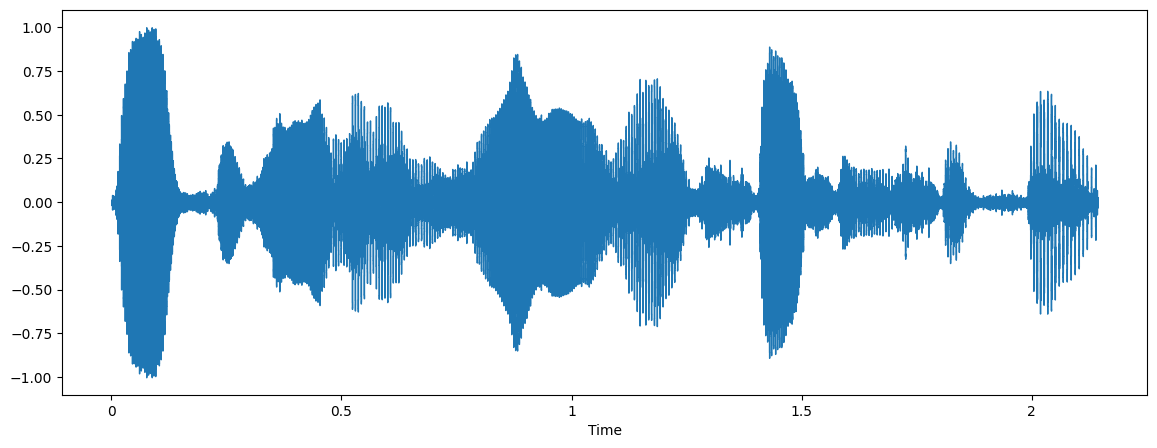

In [23]:
# visualize the output

%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
x, sr = librosa.load(output_file_path)
plt.figure(figsize=(14, 5))
librosa.display.waveshow(x, sr=sr)

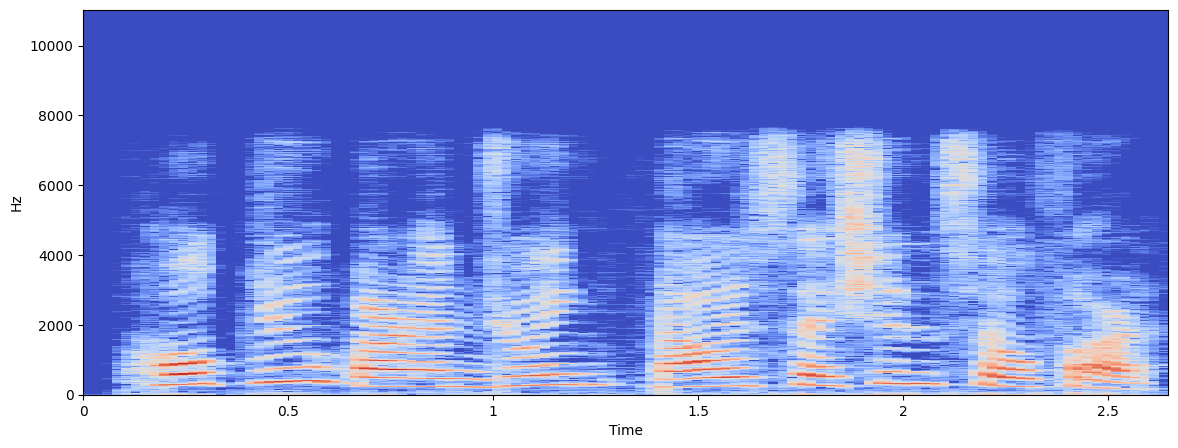

In [19]:
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')

## Cleanup

In [24]:
# teardown datamodule
data_module.teardown(stage="predict")

In [26]:
# free up GPU memory
del model